In [3]:
import json
import requests
import csv
import pandas as pd
from datetime import datetime, timedelta
import mplfinance as mpf
import time
from dateutil import parser

# Task 1a: BTC/USD 1-Day Trade History on Coinbase and Gemini
**Data Gathering - Coinbase**
* specify timeframe by iso 8601 format 
* API Call for Coinbase 
* store json as df_coinbase_aggregate



In [2]:
start_time = '2021-04-24Z'
end_time = '2021-04-25Z'

payload = {'start' : start_time, 
        'end' : end_time,
        'granularity' : 3600}

response = requests.get(url = "https://api.pro.coinbase.com/products/BTC-USD/candles", params = payload)

response_json = response.json()
coinbase_df = pd.DataFrame.from_dict(response_json)
coinbase_df.columns = ['time', 'low', 'high', 'open','close', 'volume']

**Data Gathering - Coinbase**
* specify start_time and end_time in unix milliseconds
* API Calls for Gemini while start_time <= end_time
* store json as df_gemini


In [18]:
# specify start and end time in unix milliseconds referring to previous coinbase df
start_time = coinbase_df['time'].iloc[-1]*1000 # oldest timestamp
end_time = coinbase_df['time'].iloc[0]*1000 #newest timestamp

# initialize payload and api call
payload = {'timestamp' : start_time,
            'limit_trades' : 500}

response = requests.get(url = "https://api.gemini.com/v1/trades/btcusd", params = payload)
response_json = response.json()

# initialize gemini_df to the first api call
gemini_df = pd.DataFrame.from_dict(response_json)
payload['timestamp'] = gemini_df['timestampms'].iloc[0] #timestamp = first element in gemini_df['timestampms]

# while start_time <= end_time, call api and append results to gemini_df
count = 1
while (payload['timestamp'] <= end_time):
    count += 1
    print('COUNT: ', count, '\n')
    response = requests.get(url = "https://api.gemini.com/v1/trades/btcusd", params = payload)

    # if api call is a success, append the results from the last call and update payload['timestamp']
    if (response.status_code == 200):
        response_json = response.json()
        df_temp = pd.DataFrame.from_dict(response_json)
        gemini_df = gemini_df.append(df_temp)
        payload['timestamp'] = df_temp['timestampms'].iloc[0]
        # if api call reached rate limit, sleep the program for 20 seconds
    elif (response.status_code == 429):
        time.sleep(20) 
        continue
    else:
        print(response.status_code)
        exit


**Cleaning - Coinbase**
* change time to datetime format
* set index to 'time' column
* sort by index (old-recent)
* delete last row (b/c most recent bucket includes sunday data)

In [4]:
#convert time to dt format
coinbase_df['time'] = pd.to_datetime(coinbase_df['time'], unit='s') 

# set coinbase_df index to 'time' column
coinbase_df = coinbase_df.set_index('time')

#sort by time (old -> recent)
coinbase_df = coinbase_df.sort_index()

# drop last row
coinbase_df = coinbase_df[:-1]

**Cleaning - Gemini**
* delete duplicate tids in gemini_df
* convert timestampms to datetime format 
* convert price and amount to int64
* make gemini aggregate table for OHLC - gemini_df_aggregate


In [5]:
# delete duplicates
gemini_df.drop_duplicates(subset=['tid'], inplace=True)

# convert timestamps to dt
gemini_df['timestampms'] = pd.to_datetime(gemini_df['timestampms'], unit='ms') 


# change types of price and amount
gemini_df['price']= pd.to_numeric(gemini_df['price']) 
gemini_df['amount']= pd.to_numeric(gemini_df['amount']) 

# aggregate table
# ohlc
ohlc = gemini_df.resample('H', on='timestampms').price.ohlc()
# volume
volume = gemini_df.resample('H', on='timestampms').amount.sum()
# gemini_df_aggregate
gemini_df_aggregate = pd.concat([ohlc,volume],axis = 1)

# rename ['amount'] to ['volume']
gemini_df_aggregate.rename(columns={'amount': 'volume'}, inplace=True)

# drop last row
gemini_df_aggregate = gemini_df_aggregate[:-1]

**Visualization - Coinbase**
* plot candlestick

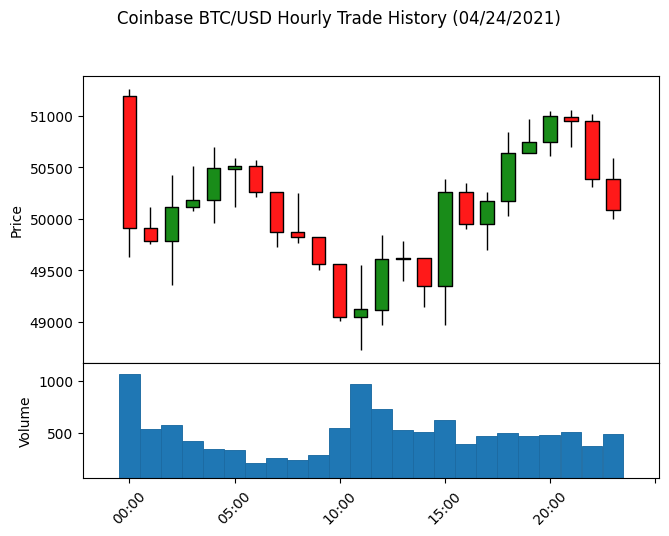

In [6]:
#graph candlestick using mplfinance
mc = mpf.make_marketcolors(up='g',down='r')
s  = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(coinbase_df,type='candle',title = 'Coinbase BTC/USD Hourly Trade History (04/24/2021)', volume=True, style =s)


**Visualization - Gemini**
* plot candlestick

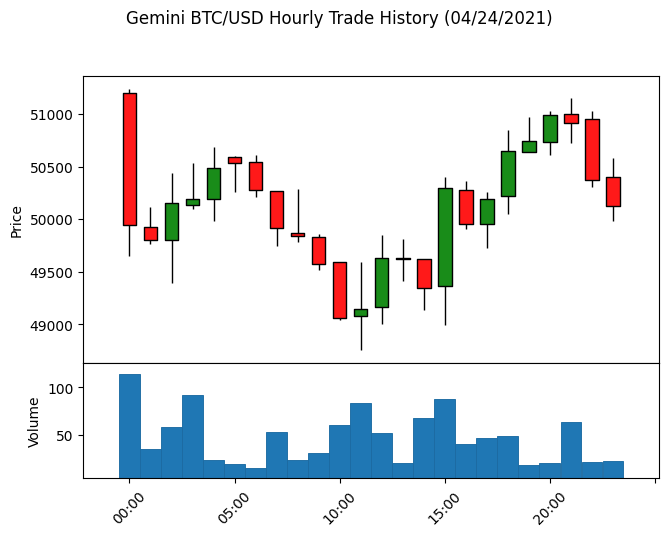

In [7]:
#graph candlestick using mplfinance
mpf.plot(gemini_df_aggregate,type='candle',title = 'Gemini BTC/USD Hourly Trade History (04/24/2021)', volume=True, style =s)

# Task 1b: ETH/BTC 1-Day Trade History on Selected Exchange (Coinbase)

**Gather - ETH/BTC from Coinbase**
* specify start_time (now) and end_time (now-1 day) in datetime
* API Calls for Coinbase, iterate using pagination from header = pageID
* store ETH/BTC 1-day trade history in df_coinbase_ethbtc


In [19]:
#call default api - get first page of most recent trades
response = requests.get(url = "https://api.pro.coinbase.com/products/ETH-BTC/trades")
response_json = response.json()

# initialize df_coinbase_ethbtc and pageID to first pg response
df_coinbase_ethbtc = pd.DataFrame.from_dict(response_json)
pageID = response.headers['cb-After']

# initialize start_time to the 'time' in df_coinbase_ethbtc (most recent)
# intialize end_time to start_time - 1day (most recent - 1 day)
start_time = datetime.strptime(df_coinbase_ethbtc['time'].iloc[0],'%Y-%m-%dT%H:%M:%S.%fZ')
end_time = start_time - timedelta(days=1)

# update start_time with the last element in the page (oldest in page)
start_time = datetime.strptime(df_coinbase_ethbtc['time'].iloc[-1],'%Y-%m-%dT%H:%M:%S.%fZ')

# iterate through the pages while start_time >= end_time, update start_time and pageID
count = 1
while (start_time >= end_time):
    count += 1
    print('COUNT: ', count, '\n')
    response = requests.get(url = ('https://api.pro.coinbase.com/products/ETH-BTC/trades' + '?after=' + pageID))

    # if api call is a success, append the results from the last call and update pageID and start_time
    if (response.status_code == 200):
        response_json = response.json()
        df_temp = pd.DataFrame.from_dict(response_json)
        df_coinbase_ethbtc = df_coinbase_ethbtc.append(df_temp)
        pageID = response.headers['cb-After']
        start_time = datetime.strptime(df_temp['time'].iloc[-1],'%Y-%m-%dT%H:%M:%S.%fZ')
        # if api call reached rate limit, sleep the program for 1 second
    elif (response.status_code == 429):
        time.sleep(1) 
        continue
    else:
        print(response.status_code)
        exit

**Gather - ETH/USD from Coinbase**
* look up eth usd price at each time and save into eth_usd_price series

In [20]:
# initialize empty series
eth_usd_price = pd.Series([])

# for every row in df_coinbase_ethbtc, call the api and retrieve the "open" price for that timestamp
for start_time in df_coinbase_ethbtc['time']:
    end_time_datetime = parser.parse(start_time) + timedelta(minutes=1)
    end_time = end_time_datetime.isoformat()[0:-6]

    response = requests.get(url = ('https://api.pro.coinbase.com/products/ETH-USD/candles?granularity=60' + '&start=' + start_time + '&end=' + end_time))

    # if status_code is not 200, attempt to sleep and retry or retry 5 times
    while (response.status_code != 200):
        retry = 0
        if (response.status_code == 429):
            time.sleep(1)
            response = requests.get(url = ('https://api.pro.coinbase.com/products/ETH-USD/candles?granularity=60' + '&start=' + start_time + '&end=' + end_time))
        else:
            while (retry < 5):
                response = requests.get(url = ('https://api.pro.coinbase.com/products/ETH-USD/candles?granularity=60' + '&start=' + start_time + '&end=' + end_time))
                retry += 1
            if (retry == 5):
                break

    response_json = response.json()
    try: # if returns in expected format
        price = response_json[0][3] # 4th json element is open price
    except: # if response body is empty, price = 0
        price = 0
    eth_usd_price = eth_usd_price.append(pd.Series(price))
    count += 1
    print('append count = ', count)



**Cleaning**
* combine df_coinbase_ethbtc and eth_usd_price series
* convert 'time' to datetime and make it the index
* filter out times that exceed 1 day
* convert size to numeric

In [16]:
# reset index for df_coinbase_ethbtc and eth_usd_price
df_coinbase_ethbtc.reset_index(drop=True, inplace=True)
eth_usd_price.reset_index(drop=True, inplace=True)

df_coinbase_ethbtc['eth_usd_price'] = eth_usd_price

#convert 'time' to datetime and make it the index
df_coinbase_ethbtc['time'] = pd.to_datetime(df_coinbase_ethbtc['time'], infer_datetime_format=True) 
print(df_coinbase_ethbtc['time'][0])
df_coinbase_ethbtc = df_coinbase_ethbtc.set_index('time')

#convert size to numeric
df_coinbase_ethbtc['size']= pd.to_numeric(df_coinbase_ethbtc['size']) 

# add new column with notional vol
df_coinbase_ethbtc['notional_vol_usd'] = df_coinbase_ethbtc['eth_usd_price']*df_coinbase_ethbtc['size']




**Visualization**
* group into hours 
* plot bar chart

<AxesSubplot:title={'center':'ETH/BTC 1 Day Notional Volume (04/27/2021 13:00 - 04/28/2021 13:00)'}, xlabel='time', ylabel='Notional Volume (million USD)'>

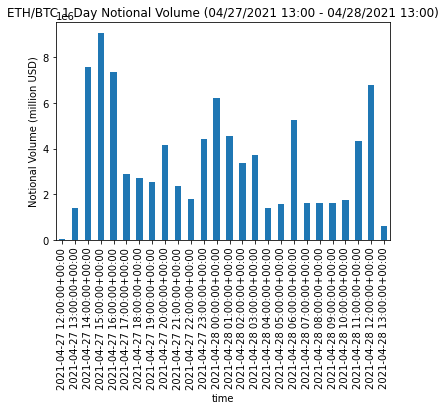

In [17]:
# PLotting the histogram
df_coinbase_ethbtc_aggregate = df_coinbase_ethbtc.groupby(pd.Grouper(freq='1H')).notional_vol_usd.sum()

df_coinbase_ethbtc_aggregate.plot(kind='bar', title = 'ETH/BTC 1 Day Notional Volume (04/27/2021 13:00 - 04/28/2021 13:00)', ylabel = 'Notional Volume (million USD)')